# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [28]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Алгоритм минимизирует суммарное квадратичное отклонение точек от центров кластеров. Каждый объект может принадлежать одному из k кластеров => всего возможных вариатов разить N объектов k^N штук. На каждой итерации алгоритма сум. кв. откл. не увеличивается и кол-во итераций ограничено, следовательно по Th Вейерштрасса сходится.

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

***Ваше решение здесь***

$\ln p(x_i|\theta) = -\frac{1}{2} \ln \left[ (2 \pi)^n \left|\Sigma \right| \right] -\frac{1}{2} \left( x_i - \mu \right)^T \Sigma^{-1} \left( x_i - \mu \right) $

$\frac{\partial}{\partial \mu} \ln p(x_i|\theta) = -\frac{1}{2} \left( \Sigma^{-1} + \left(\Sigma^{-1}\right)^T \right) (x_i - \mu) = \Sigma^{-1} (\mu - x_i)$

$ \frac{\partial}{\partial \mu} \ln L(\theta) = \sum_{i=1}^N \Sigma^{-1} (\mu - x_i) = 0$

$ \Rightarrow N \cdot \mu - \sum_{i=1}^N x_i = 0 \Rightarrow \mu = \frac{1}{N} \sum_{i=1}^N x_i $

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

$min(A, B) = \frac{1}{2}(A + B - |A - B|)$, если A < B, то $min(A, B) = \frac{1}{2}A + \frac{1}{2}B - \frac{1}{2}B + \frac{1}{2}A  = A$, аналогично и для A >= B

$max(A, B) = \frac{1}{2}(A + B + |A - B|)$, если A < B, то $max(A, B) = \frac{1}{2}A + \frac{1}{2}B + \frac{1}{2}B - \frac{1}{2}A  = B$, аналогично и для A >= B.

$d_{\min}(U \cup V, S) = min(d_{\min}(U, S), d_{\min}(V, S)) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |$

$d_{\max}(U \cup V, S) = max(d_{\max}(U, S), d_{\max}(V, S))= \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) | $

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [41]:
from sklearn.base import BaseEstimator, ClusterMixin

from copy import deepcopy
import sklearn
import numpy


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, metric='euclidean', n_clusters=2, linkage='average'):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters = n_clusters
        
        if metric == 'euclidean':
            self.dist_func = sklearn.metrics.pairwise.euclidean_distances
        elif metric == 'manhattan':
            self.dist_func = sklearn.metrics.pairwise.manhattan_distances
        elif metric == 'cosine':
            self.dist_func = sklearn.metrics.pairwise.cosine_distances
        
        def complete(i_row, j_row, i_c, j_c):
            return 0.5 * i_row + 0.5 * j_row + 0.5 * np.absolute(i_row - j_row)
        def single(i_row, j_row, i_c, j_c):
            return 0.5 * i_row + 0.5 * j_row - 0.5 * np.absolute(i_row - j_row)
        def average(i_row, j_row, i_c, j_c):
            return (i_c/(i_c + j_c)) * i_row + (j_c/(i_c + j_c)) * j_row
        
        if linkage == "complete":
            self.link_func = complete
        elif linkage == "single":
            self.link_func = single
        elif linkage == "average":
            self.link_func = average
            
        self.dendrogram_data = []
        
    def fit_predict(self, X):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        distances = np.array(self.dist_func(X, X))
        np.fill_diagonal(distances, np.inf)
        
        clusters_size = np.arange(X.shape[0])
        clusters = [[i] for i in range(X.shape[0])]
        
        for i in range(1, X.shape[0]):
            left, right = np.unravel_index(np.argmin(distances), distances.shape)
            
            self.dendrogram_data.append([clusters_size[left],
                                         clusters_size[right],
                                         distances[(left, right)],
                                         len(clusters[left]) + len(clusters[right])])
            
            i_row = np.append(distances[:left, left], distances[left, left + 1:])
            j_row = np.append(distances[:right, right], distances[right, right + 1:])
            
            updated_dist = self.link_func(i_row, j_row, clusters_size[left], clusters_size[right])
            
            clusters_size[left] = X.shape[0] + i - 1
            clusters_size = np.delete(clusters_size, right, 0)
            
            distances[:left, left] = updated_dist[:left]
            distances[left, left + 1:] = updated_dist[left:]
            
            distances = np.delete(distances, right, axis=0)
            distances = np.delete(distances, right, axis=1)
            
            clusters[left] = np.append(clusters[left], clusters[right])
            clusters = np.delete(clusters, right, axis=0)
            
            if X.shape[0] - i == self.n_clusters:
                final_clusters = deepcopy(clusters)
                
        preds = np.zeros(X.shape[0], dtype=int)
        for i in range(self.n_clusters):
            preds[final_clusters[i]] = i
        
        return preds
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        scipy.cluster.hierarchy.dendrogram(self.dendrogram_data)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

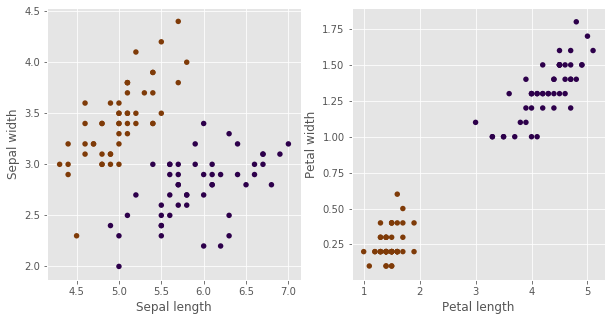

In [38]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [39]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.004000186920166016


In [42]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering()
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.09000515937805176


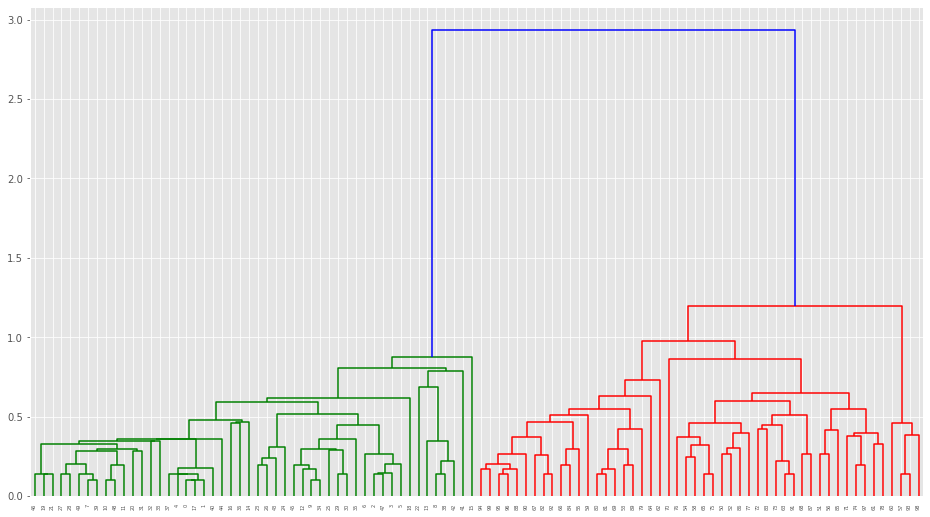

In [43]:
plt.figure(figsize=(16,9))
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

Можно. Аномалии обычно заходят в группу последними, их можно увидеть так.

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

Косинусовое

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

Под 0.45

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Результаты кластеризации можно использовать как фичи

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [44]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [45]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_titles = pd.read_csv("docs_titles.tsv", sep='\t')
vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit(df_titles.title.fillna(""))

In [61]:
full_target = np.array(train_data['target'])
for linkage in ['single', 'complete', 'average']:
    for metric in ['cosine', 'euclidean']:
        predictions = []

        for key in traingroups_titledata:
            titles = [t[1] for t in traingroups_titledata[key]]
            target = [t[2] for t in traingroups_titledata[key]]
    
            X = vectorizer.transform(titles)
            cluster = Clustering(metric=metric, linkage=linkage)
            pred = cluster.fit_predict(X)
            (label1, label2), (count1, count2) = np.unique(pred, return_counts=True)
            least_cluster = label1 if count1 < count2 else label2
            predictions.extend(np.asarray(pred != least_cluster, dtype=int))
        score = f1_score(full_target, predictions)
        print(metric, linkage, score)

cosine single 0.4473490180306991
euclidean single 0.44721496078825657
cosine complete 0.42192890355482227
euclidean complete 0.42887897893280025
cosine average 0.44343400067865624
euclidean average 0.4428069226608978


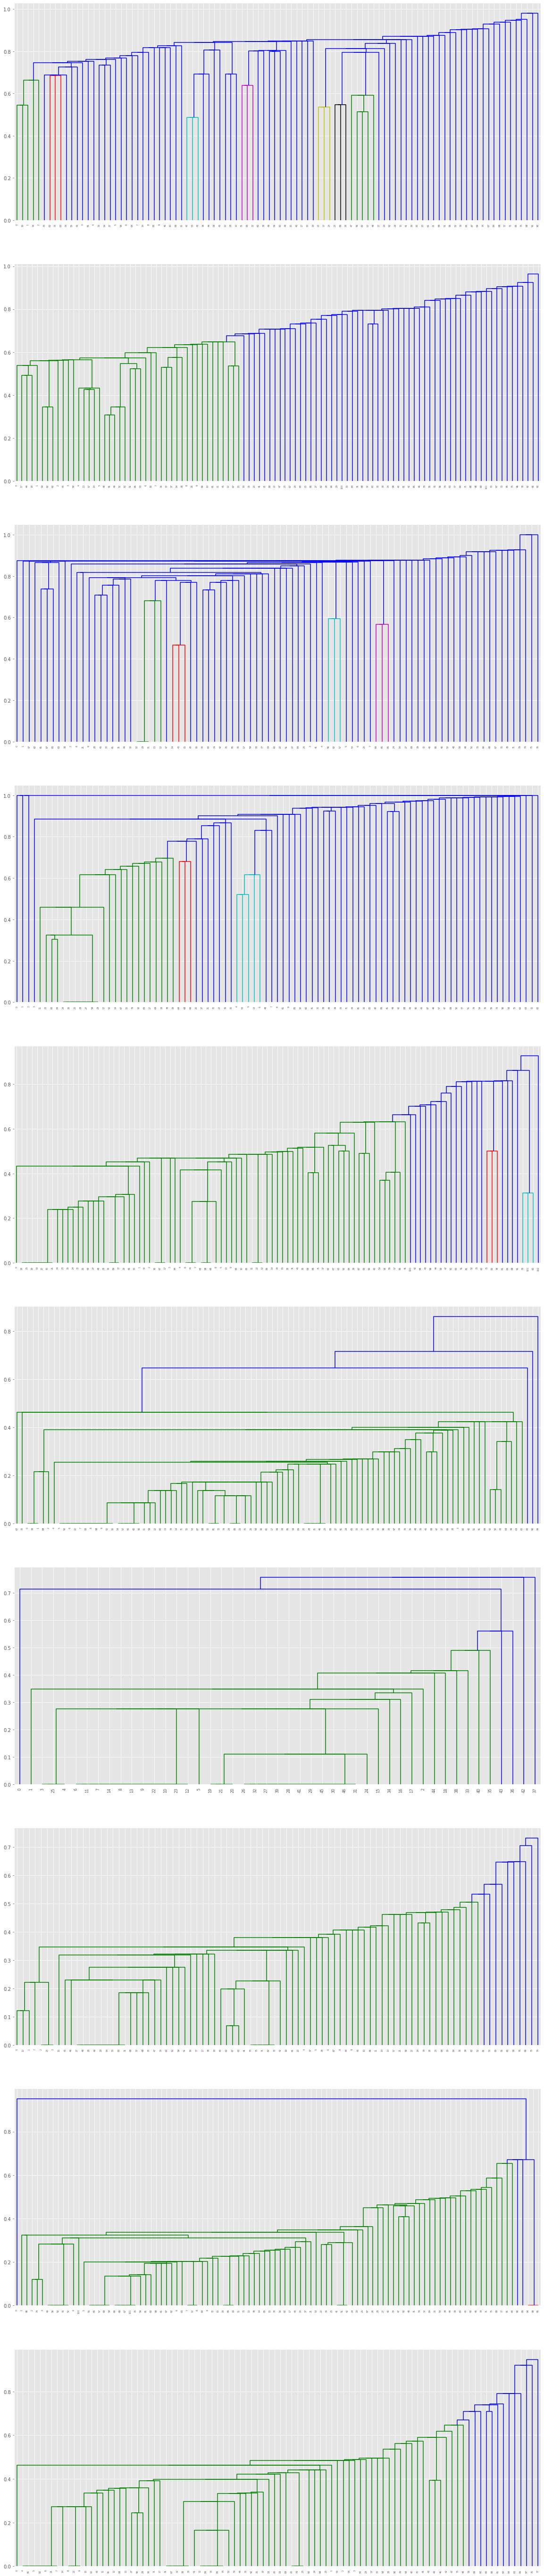

In [64]:
indices = np.random.choice(list(traingroups_titledata.keys()), 10)
pl.figure(figsize=(20, 100))
for i, ind in enumerate(indices):
    plt.subplot(10, 1, i + 1)
    titles = [t[1] for t in traingroups_titledata[ind]]
    target = [t[2] for t in traingroups_titledata[ind]]
    X = vectorizer.transform(titles)
    
    cluster = Clustering(metric='cosine', n_clusters=2, linkage="single")
    pred = cluster.fit_predict(X)
    cluster.plot_dendrogram()

In [65]:
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer


full_target = np.array(train_data['target'])
predictions = []

for key in traingroups_titledata:
    titles = [t[1] for t in traingroups_titledata[key]]
    target = [t[2] for t in traingroups_titledata[key]]
    
    X = vectorizer.transform(titles)
    cluster = Clustering(metric='cosine', n_clusters=2, linkage='single')
    pred = cluster.fit_predict(X)
    (label1, label2), (count1, count2) = np.unique(pred, return_counts=True)
    least_cluster = label1 if count1 < count2 else label2
    predictions.extend(np.asarray(pred != least_cluster, dtype=int))
f1_score(full_target, predictions)

0.4473490180306991

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.